In [1]:
import pandas as pd
import numpy as np
import pickle
from surprise import BaselineOnly
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from surprise import SVD
from surprise import SVDpp
from surprise import NMF

from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor
from surprise import KNNBasic

from os import path

#from surprise import KNNBaseline
#from surprise import prediction_algorithms.matrix

In [2]:
sampleFile = open('subset_df.pkl','rb')
subset_df = pickle.load(sampleFile)

In [23]:
play_count_quantiles = np.quantile(subset_df['play_count'],q=[i/100 for i in range(0,101,25)])

In [25]:
play_count_quantiles

array([1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 1.762e+03])

In [50]:
def getQuantileParam(m):
    return [i/100 for i in range(0,101,m)]

In [47]:
## Find the number of times a song has been heard
no_times_song_heard = np.quantile(subset_df.groupby(['song_id']).sum().play_count,q=getQuantileParam(10))
## Find the number of users have listened to the song

In [52]:
# Number of users who have heard a song
no_users_heard_song = np.quantile(subset_df['song_id'].value_counts().values,q=getQuantileParam(10))

In [53]:
no_users_heard_song

array([1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
       4.0000e+00, 6.0000e+00, 1.0000e+01, 1.9000e+01, 4.6000e+01,
       1.0388e+04])

In [71]:
## We select the threshold to be 4 which suggests that atleast 50% of the population has heard a song for 4 times
## We create a subset of those songs which have been heard atleast 4 times

In [76]:
songs_index = subset_df['song_id'].value_counts()[subset_df['song_id'].value_counts() >= 4].index

In [72]:
## Number of songs heard by a user
## We'll select the subset of users who have heard atleast more than the threshold number of songs

In [73]:
no_songs_heard_user = np.quantile(subset_df['user_id'].value_counts().values,q=getQuantileParam(10))

In [74]:
no_songs_heard_user

array([  1.,   1.,   1.,   1.,   1.,   2.,   2.,   3.,   4.,   6., 169.])

In [77]:
user_index = subset_df['user_id'].value_counts()[subset_df['user_id'].value_counts() >= 4].index

In [81]:
print("Number of Unique songs : ",subset_df['song_id'].nunique())
print("Number of Unique users : ",subset_df['user_id'].nunique())

Number of Unique songs :  77135
Number of Unique users :  635627


In [84]:
print("Number of selected songs : ",len(songs_index))
print("Number of selected users : ",len(user_index))

Number of selected songs :  39953
Number of selected users :  158241


In [97]:
print("% of selected songs : ",len(songs_index)*100/subset_df['song_id'].nunique())
print("% of selected users : ",len(user_index)*100/subset_df['user_id'].nunique())

% of selected songs :  51.79620146496402
% of selected users :  24.895260899867374


In [98]:
 ## Selecting songs from subset_df based on songs_index

In [107]:
updt_subset_df = subset_df[subset_df['song_id'].isin(songs_index) & subset_df['user_id'].isin(user_index)]
print("Size of Original Dataframe : ",len(subset_df))
print("Size of shrinked Dataframe : ",len(updt_subset_df)*100/len(subset_df),"%")

Size of Original Dataframe :  1857407
Size of shrinked Dataframe :  56.03839115498111 %


## Saving the Updated DataFrame

In [128]:
sampleFile = open('updt_subset_df','wb')
pickle.dump(updt_subset_df,sampleFile)
sampleFile.close()

In [4]:
sampleFile = open('updt_subset_df','rb')
updt_subset_df = pickle.load(sampleFile)
sampleFile.close()

C:\Users\manish_jathan\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='play_count', ylabel='Density'>

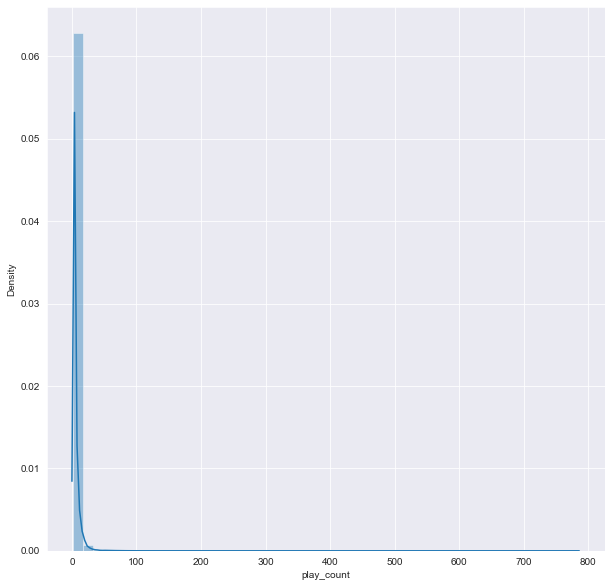

In [133]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
sns.distplot(updt_subset_df.play_count)

C:\Users\manish_jathan\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='play_count'>

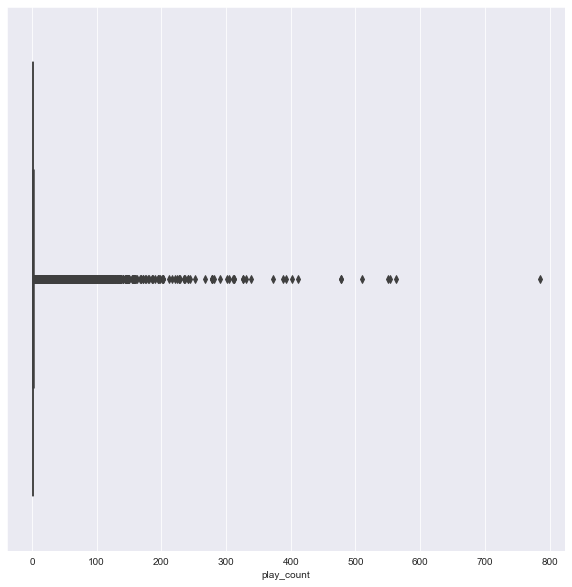

In [137]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,10))
sns.boxplot(updt_subset_df['play_count'])

C:\Users\manish_jathan\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='play_count', ylabel='Density'>

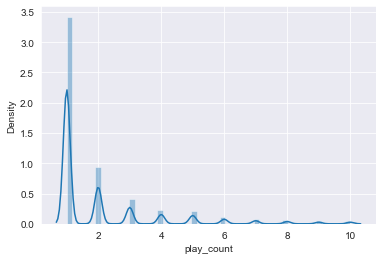

In [145]:
sns.distplot(updt_subset_df[updt_subset_df['play_count']<=10]['play_count'])

In [151]:
np.quantile(updt_subset_df['play_count'],getQuantileParam(10))

array([  1.,   1.,   1.,   1.,   1.,   1.,   2.,   2.,   3.,   5., 785.])

* Looking at the quantile ranges
* we can try to reduce the size of data by considering only those playcounts less than or equal to 5

## Saving the final dataframe

In [8]:
final_df = updt_subset_df[updt_subset_df['play_count']<=5]

In [9]:
print("% shrinkage in size : ",((updt_subset_df.shape[0] - final_df.shape[0])*100)/updt_subset_df.shape[0])

% shrinkage in size :  9.154056113160163


In [10]:
final_df.shape

(945580, 3)

In [11]:
sampleFile = open('final_df','wb')
pickle.dump(final_df,sampleFile)
sampleFile.close()

In [8]:
sampleFile = open('final_df','rb')
final_df = pickle.load(sampleFile)
sampleFile.close()

## 1. Baseline Model

In [218]:
## Defining the Parameter grid
bsl_param_grid = {'bsl_options' : {'method' : ['als','sgd'],
                                   'n_epochs' : [i for i in range(1,11)],
                                   'reg_u' : [i for i in range(3,12,3) ],
                                   'reg_i' : [i for i in range(5,21,5)]}
                 }

## Preparing the dataset for train and test

In [9]:
## Let's divide the data into train and test set
reader = Reader(rating_scale=(1,5))
train_data,test_data = train_test_split(final_df,test_size = 0.3)

train_set = Dataset.load_from_df(train_data,reader)
test_set = Dataset.load_from_df(test_data,reader)

In [17]:
train_set_obj = train_set.build_full_trainset()

In [126]:
train_set_test_obj = train_set_obj.build_testset()

In [10]:
test_set_daf_obj = test_set.build_full_trainset()
test_set_obj = test_set_daf_obj.build_testset()

In [407]:
dumpObj(train_set_obj,'train_set_obj')
dumpObj(train_set_test_obj,'train_set_test_obj')
dumpObj(test_set_obj,'test_set_obj')
dumpObj(train_set,'train_set')
dumpObj(test_set,'test_set')
dumpObj(train_data,'train_data')
dumpObj(test_data,'test_data')

In [5]:
train_set_obj = returnObj('train_set_obj')
train_set_test_obj = returnObj('train_set_test_obj')
test_set_obj = returnObj('test_set_obj')
train_set = returnObj('train_set')
test_set = returnObj('test_set')
train_data = returnObj('train_data')
test_data = returnObj('test_data')

In [ ]:
## Initializing the Grid Search CV and fitting the train data
gcv = GridSearchCV(BaselineOnly,
                   bsl_param_grid,
                   measures=['rmse','mae'],
                   cv=3)
gcv.fit(train_data)

In [220]:
pd.DataFrame(gcv.cv_results)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_bsl_options
0,1.053778,1.050428,1.051071,1.051759,0.001452,180,0.775862,0.774817,0.775104,0.775261,0.000441,2,0.865285,0.051785,2.922506,0.473516,"{'bsl_options': {'method': 'als', 'n_epochs': ...","{'method': 'als', 'n_epochs': 1, 'reg_u': 3, '..."
1,1.050249,1.046671,1.047482,1.048134,0.001532,109,0.775894,0.774699,0.775050,0.775214,0.000502,1,0.333687,0.007513,2.824808,0.489791,"{'bsl_options': {'method': 'als', 'n_epochs': ...","{'method': 'als', 'n_epochs': 1, 'reg_u': 3, '..."
2,1.048945,1.045258,1.046166,1.046790,0.001568,89,0.776437,0.775174,0.775532,0.775714,0.000531,3,0.405788,0.069902,3.550119,0.972309,"{'bsl_options': {'method': 'als', 'n_epochs': ...","{'method': 'als', 'n_epochs': 1, 'reg_u': 3, '..."
3,1.048341,1.044592,1.045555,1.046162,0.001590,62,0.777019,0.775717,0.776080,0.776272,0.000549,5,0.317628,0.030305,2.552970,0.665288,"{'bsl_options': {'method': 'als', 'n_epochs': ...","{'method': 'als', 'n_epochs': 1, 'reg_u': 3, '..."
4,1.049371,1.046179,1.047072,1.047541,0.001344,90,0.783134,0.782532,0.782879,0.782849,0.000247,41,0.335909,0.007057,2.876276,0.536704,"{'bsl_options': {'method': 'als', 'n_epochs': ...","{'method': 'als', 'n_epochs': 1, 'reg_u': 6, '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,1.050045,1.046985,1.048252,1.048427,0.001255,111,0.797116,0.796779,0.797514,0.797136,0.000301,129,1.786054,0.031412,1.511468,0.310415,"{'bsl_options': {'method': 'sgd', 'n_epochs': ...","{'method': 'sgd', 'n_epochs': 10, 'reg_u': 6, ..."
236,1.050045,1.046985,1.048252,1.048427,0.001255,119,0.797116,0.796779,0.797514,0.797136,0.000301,130,1.853122,0.099205,1.634170,0.286919,"{'bsl_options': {'method': 'sgd', 'n_epochs': ...","{'method': 'sgd', 'n_epochs': 10, 'reg_u': 9, ..."
237,1.050045,1.046985,1.048252,1.048427,0.001255,110,0.797116,0.796779,0.797514,0.797136,0.000301,131,2.110701,0.454237,1.775244,0.448686,"{'bsl_options': {'method': 'sgd', 'n_epochs': ...","{'method': 'sgd', 'n_epochs': 10, 'reg_u': 9, ..."
238,1.050045,1.046985,1.048252,1.048427,0.001255,121,0.797116,0.796779,0.797514,0.797136,0.000301,127,1.774862,0.011656,1.771940,0.430656,"{'bsl_options': {'method': 'sgd', 'n_epochs': ...","{'method': 'sgd', 'n_epochs': 10, 'reg_u': 9, ..."


In [222]:
gcv.best_params['rmse']

{'bsl_options': {'method': 'als', 'n_epochs': 2, 'reg_u': 6, 'reg_i': 20}}

In [223]:
 gcv.best_score['rmse']

1.041419298530762

In [10]:
best_params = {'bsl_options': {'method': 'als',
                               'n_epochs': 2,
                               'reg_u': 6,
                               'reg_i': 20}
              }
best_baseline = BaselineOnly(best_params)

In [52]:
best_baseline.fit(train_data)

Estimating biases using als...


In [55]:
predictions = best_baseline.test(test_data)

In [58]:
## Results on Test Data
print(accuracy.mse(predictions))
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

MSE: 1.0856
1.0856056622894739
RMSE: 1.0419
1.0419240194416644
MAE:  0.7891
0.7891473934159209


In [67]:
model_params = str({"method": "als","n_epochs": 2,"reg_u": 6,"reg_i": 20})

In [73]:
test_results_df = pd.DataFrame({'model' : ['baseline'],
                               'model_params': [model_params],
                               'mse':[1.0856],
                               'rmse':[1.0419],
                               'mae':[0.7891]})
test_results_df

,model,model_params,mse,rmse,mae
0,baseline,"{'method': 'als', 'n_epochs': 2, 'reg_u': 6, '...",1.0856,1.0419,0.7891


## 2.Normal Predictor
* Let's try Normal Predictor and check how good are the results

In [79]:
normal_predictor = NormalPredictor()
normal_predictor.fit(train_data)
normal_predictions = normal_predictor.test(test_data)

In [80]:
print(accuracy.mse(normal_predictions))
print(accuracy.rmse(normal_predictions))
print(accuracy.mae(normal_predictions))

MSE: 1.8630
1.862968610956503
RMSE: 1.3649
1.3649060813684226
MAE:  0.9959
0.9959250715455104


In [92]:
test_results_df = test_results_df.append({'model': 'Normal_predictor','model_params':'','mse':1.8630,'rmse':1.3649,'mae':0.9959},ignore_index=True)

In [93]:
test_results_df

,model,model_params,mse,rmse,mae
0,baseline,"{'method': 'als', 'n_epochs': 2, 'reg_u': 6, '...",1.0856,1.0419,0.7891
1,Normal_predictor,,1.8630,1.3649,0.9959


## 3.Similarity Measure based KNN

In [105]:
param_grid = {
        'k' : [i for i in range(5,21,5)],
        'sim_options' : {
            'name' : ['msd','cosine','pearson','pearson_baseline'],
            'user_based' : [True]
        },
        'verbose': [False]
}

In [107]:
gcv = GridSearchCV(KNNBasic,param_grid,cv=3)

In [117]:
train_data,test_data=train_test_split(final_df)

In [119]:
train_data.shape

(709185, 3)

In [120]:
test_data.shape

(236395, 3)

In [122]:
train_set = Dataset.load_from_df(train_data,reader)

* Got Memory restrictions using KNN.
* As it has to create a similarity matrix and requires about 165GB of memory.

## 4. Matrix Factorization methods
### 4.1 SVD 

In [158]:
param_grid = {
        'n_factors' : [i for i in range(20,110,40)],
        'n_epochs' : [j for j in range(20,110,40)],
        'biased':[True],
        'lr_all':[0.001*i for i in range(2,6,1)],
        'reg_all':[0.01*j for j in range(2,6,1)],
        'random_state':[42],
        'verbose':[True]
}

In [159]:
param_grid

{'n_factors': [20, 60, 100],
 'n_epochs': [20, 60, 100],
 'biased': [True],
 'lr_all': [0.002, 0.003, 0.004, 0.005],
 'reg_all': [0.02, 0.03, 0.04, 0.05],
 'random_state': [42],
 'verbose': [True]}

In [160]:
gcv = GridSearchCV(SVD,param_grid,cv=3)

In [ ]:
gcv.fit(train_set)

### 4.2 Saving SVD GCV Object

In [162]:
sampleFile = open('SVD_GridSearchCVObject','wb')
pickle.dump(gcv,sampleFile)
sampleFile.close()

In [20]:
sampleFile = open('SVD_GridSearchCVObject','rb')
gcv = pickle.load(sampleFile)
sampleFile.close()

In [164]:
svd_gcv_results = pd.DataFrame(gcv.cv_results)

### 4.3 Saving the Grid Search CV Object for SVD

In [167]:
sampleFile = open('svd_gcv_results','wb')
pickle.dump(svd_gcv_results,sampleFile)
sampleFile.close()

In [19]:
sampleFile = open('svd_gcv_results','rb')
svd_gcv_results = pickle.load(sampleFile)
sampleFile.close()

In [168]:
gcv.best_score['rmse']

1.0447719085861091

In [169]:
gcv.best_params['rmse']

{'n_factors': 20,
 'n_epochs': 20,
 'biased': True,
 'lr_all': 0.005,
 'reg_all': 0.02,
 'random_state': 42,
 'verbose': True}

In [170]:
gcv.best_params['mae']

{'n_factors': 100,
 'n_epochs': 100,
 'biased': True,
 'lr_all': 0.005,
 'reg_all': 0.05,
 'random_state': 42,
 'verbose': True}

In [172]:
gcv.best_score['mae']

0.7645253457990907

### 4.4 Building a model out of best parameters based on RMSE 

In [93]:
svd = SVD(n_factors = 20,
          n_epochs = 20,
          biased = True,
          lr_all = 0.005,
          reg_all = 0.02,
          random_state = 42,
          verbose = True)

In [ ]:
svd.fit(train_set_obj)

In [124]:
test_results = svd.test(test_set_obj)

In [127]:
## Results on Test Data
print(accuracy.mse(test_results))
print(accuracy.rmse(test_results))
print(accuracy.mae(test_results))

MSE: 1.0700
1.0699991113823952
RMSE: 1.0344
1.0344076137492393
MAE:  0.7712
0.7712473920996156


In [132]:
test_results_df

,model,model_params,mse,rmse,mae
0,baseline,"{'method': 'als', 'n_epochs': 2, 'reg_u': 6, '...",1.0856,1.0419,0.7891
1,Normal_predictor,,1.8630,1.3649,0.9959


In [166]:
test_results_df = test_results_df.append({'model': 'SVD','model_params':gcv.best_params['rmse'],'mse':1.0700,'rmse':1.0344,'mae':0.7712},ignore_index=True)

In [148]:
sampleFile = open('svd','wb')
pickle.dump(svd,sampleFile)
sampleFile.close()

In [150]:
print(svd.pu.shape)
print(svd.qi.shape)

(155283, 20)
(38079, 20)


Pu and Qi features provide us with vectors to find similarities between users and items

### 4.5 Building a model based on best parameters of MAE

In [160]:
gcv.best_params['mae']

{'n_factors': 100,
 'n_epochs': 100,
 'biased': True,
 'lr_all': 0.005,
 'reg_all': 0.05,
 'random_state': 42,
 'verbose': True}

In [ ]:
svd = SVD(n_factors=100,n_epochs= 100,biased=True,
         lr_all=0.005,reg_all=0.05,random_state=42,
         verbose=True)
svd.fit(train_set_obj)

In [162]:
test_results = svd.test(test_set_obj)

In [163]:
## Results on Test Data
print(accuracy.mse(test_results))
print(accuracy.rmse(test_results))
print(accuracy.mae(test_results))

MSE: 1.0813
1.0813104425425235
RMSE: 1.0399
1.039860780365585
MAE:  0.7488
0.7487649005266127


In [164]:
test_results_df.append({'model': 'SVD','model_params':gcv.best_params['mae'],'mse':1.0813,'rmse':1.0399,'mae':0.7488},ignore_index=True)

,model,model_params,mse,rmse,mae
0,baseline,"{'method': 'als', 'n_epochs': 2, 'reg_u': 6, '...",1.0856,1.0419,0.7891
1,Normal_predictor,,1.8630,1.3649,0.9959
2,SVD,"{'n_factors': 100, 'n_epochs': 100, 'biased': ...",1.0813,1.0399,0.7488


In [169]:
test_results_df=test_results_df.append({'model': 'SVD','model_params':gcv.best_params['mae'],'mse':1.0813,'rmse':1.0399,'mae':0.7488},ignore_index=True)

In [172]:
test_results_df.drop(axis=0,index=3,inplace=True)

In [173]:
test_results_df.head()

,model,model_params,mse,rmse,mae
0,baseline,"{'method': 'als', 'n_epochs': 2, 'reg_u': 6, '...",1.0856,1.0419,0.7891
1,Normal_predictor,,1.8630,1.3649,0.9959
2,SVD,"{'n_factors': 20, 'n_epochs': 20, 'biased': Tr...",1.0700,1.0344,0.7712
4,SVD,"{'n_factors': 100, 'n_epochs': 100, 'biased': ...",1.0813,1.0399,0.7488


In [174]:
sampleFile = open('svd_mae','wb')
pickle.dump(svd,sampleFile)
sampleFile.close()

* After realising that it took almost two and a half days for the SVD algorithm to complete its execution
* I'll now first try the SVDpp and NMF with their default parameters and see if there is any major difference in mse,rmse and mae values without hyper-parameter tuning
* Let's try with SVDpp

## 4.6 SVDpp

In [178]:
svdpp = SVDpp()
svdpp.fit(train_set_obj)

In [179]:
svdpp_test_results = svdpp.test(test_set_obj)
print(accuracy.mse(svdpp_test_results))
print(accuracy.rmse(svdpp_test_results))
print(accuracy.mae(svdpp_test_results))

MSE: 1.0820
1.0819692504481035
RMSE: 1.0402
1.0401775091051064
MAE:  0.7602
0.7601776878098543


* Will not waste my time doing unnecessary hyper-parameter tuning

In [181]:
sampleFile = open('svd_pp','wb')
pickle.dump(svdpp,sampleFile)
sampleFile.close()

In [182]:
test_results_df = test_results_df.append({'model': 'SVD_pp','model_params':'','mse':1.0820,'rmse':1.0402,'mae':0.7602},ignore_index=True)

In [183]:
test_results_df.head()

,model,model_params,mse,rmse,mae
0,baseline,"{'method': 'als', 'n_epochs': 2, 'reg_u': 6, '...",1.0856,1.0419,0.7891
1,Normal_predictor,,1.8630,1.3649,0.9959
2,SVD,"{'n_factors': 20, 'n_epochs': 20, 'biased': Tr...",1.0700,1.0344,0.7712
3,SVD,"{'n_factors': 100, 'n_epochs': 100, 'biased': ...",1.0813,1.0399,0.7488
4,SVD_pp,,1.0820,1.0402,0.7602


### 4.7 NMF(Non Negative Matrix Factorization)

In [186]:
nmf = NMF()
nmf.fit(train_set_obj)
nmf_test_results = nmf.test(test_set_obj)

print(accuracy.mse(nmf_test_results))
print(accuracy.rmse(nmf_test_results))
print(accuracy.mae(nmf_test_results))

MSE: 1.2726
1.2725617526565394
RMSE: 1.1281
1.1280787883195655
MAE:  0.6931
0.6930968342663446


In [206]:
sampleFile = open('nmf','wb')
pickle.dump(nmf,sampleFile)
sampleFile.close()

In [199]:
test_results_df['model_params'].replace({'': 'default'},inplace=True)

### 4.8  Slope One

In [201]:
from surprise import SlopeOne

In [202]:
slopeOne = SlopeOne()

In [203]:
slopeOne.fit(train_set_obj)

<ipython-input-203-c284bd264695>:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  slopeOne.fit(train_set_obj)


In [204]:
slopeOne_test_results = slopeOne.test(test_set_obj)

In [205]:
print(accuracy.mse(slopeOne_test_results))
print(accuracy.rmse(slopeOne_test_results))
print(accuracy.mae(slopeOne_test_results))

MSE: 1.4240
1.424030675487326
RMSE: 1.1933
1.193327564203277
MAE:  0.7953
0.7952900539264449


In [217]:
sampleFile = open('test_results_df','wb')
pickle.dump(test_results_df,sampleFile)
sampleFile.close()

* Let's  import the hashed song_ids and item_ids
* Let's obtain the song name after that

In [3]:
def returnObj(fileName):
    if path.exists(fileName):
        sampleFile = open(fileName,'rb')
        obj = pickle.load(sampleFile)
        sampleFile.close()
        return obj
    else:
        return "fileName doesn't exist"

In [4]:
def dumpObj(obj,fileName):
    sampleFile = open(fileName,'wb')
    pickle.dump(obj,sampleFile)
    sampleFile.close()

In [6]:
merge_ui_df = returnObj('merge_ui_df.pkl')

In [15]:
## Trying Similarity Based KNN method

In [14]:
sim_options = {'name' : 'cosine',
               'user_based' : False,
               }
algo = KNNBasic(sim_options = sim_options)
algo

In [22]:
train_data.song_id.nunique()

38091

In [37]:
## creating a similarity matrix using the found ratings is difficult
## We'll try to leverage the latent factors obtained for the items and users in svd model 
## and try to create a similarity matrix out of it
## But there's no clear documentation of the indices representation

In [39]:
#Let's compute the similarity for a single item at run time

In [9]:
svd = returnObj('svd')

In [8]:
def findSimilarUsers(u1):
    ## Get the list of all Users
    unique_users = train_data['user_id'].unique()
    # Iterating through all the users
    for u2 in unique_users:
        if u1!=u2:
            common_songs = findCommonSongs(u1,u2)
            if common_songs != 0:
                print("UserId : " ,u2)
                print("Common Songs : ",common_songs)

                
def findCommonSongs(u1,u2):
    u1_songs = set(train_data[train_data['user_id']==u1]['song_id'].values)
    u2_songs = set(train_data[train_data['user_id']==u2]['song_id'].values)
    common_songs = u1_songs.intersection(u2_songs)
    if len(common_songs)==0:
        return 0
    else:
        return common_songs

In [7]:
## Helper function 1
def return_min(similar_items_dict):
    min = 10000
    for value in similar_items_dict.keys():
        if value < min:
            min = value
    return min

def computeUserItemVector(user_item_flag,ui):
    ## Prepare the list of item vector
    unique_songs = train_data.song_id.unique()
    triplet_list = []
    mean_rating = np.mean(train_data['play_count'])
    ## Create user,item,rating triplet
    for song in unique_songs:
        triplet_list.append((ui,song,mean_rating))
    pred = svd.test(triplet_list)
    est_values = pd.DataFrame(pred)['est'].values
    return est_values

## Helper function 2
def computeUserItemSimilarity(user_item_flag,latent_factor_flag,i1,i2,sim_method):
    ##Converting raw_ids to svd's internal representation
    sim = 0
    vec_1 = np.array(20)
    vec_2 = np.array(20)
    
    if user_item_flag=='user' and latent_factor_flag==True:
        id_1 = train_set_obj.to_inner_uid(i1)
        id_2 = train_set_obj.to_inner_uid(i2)
        vec_1 = svd.pu[id_1]
        vec_2 = svd.pu[id_2]
        
    elif user_item_flag=='user' and latent_factor_flag==False:
        id_1 = train_set_obj.to_inner_uid(i1)
        id_2 = train_set_obj.to_inner_uid(i2)
        vec_1 = computeUserItemVector(user_item_flag,i1)
        vec_2 = computeUserItemVector(user_item_flag,i2)
        
    elif user_item_flag == 'item' and latent_factor_flag==True:
        id_1 = train_set_obj.to_inner_iid(i1)
        id_2 = train_set_obj.to_inner_iid(i2)
        vec_1 = svd.qi[id_1]
        vec_2 = svd.qi[id_2]
    
    
    # Cosine similarity between items
    if sim_method == 'cosine':
        std_i1_vec = np.sqrt(np.sum(np.square(vec_1)))
        std_i2_vec = np.sqrt(np.sum(np.square(vec_2)))
        sim = (np.dot(vec_1,vec_2))/((std_i1_vec*std_i2_vec))
    
    ## Mean Squared Distance
    elif sim_method == 'msd':
        sim = (np.sum(np.square(vec_1-vec_2)))/len(vec_1)
        
    ## Pearson Correlation Coefficient
    elif sim_method == 'pearson':
        i1_cval = vec_1-np.mean(vec_1)
        i2_cval = vec_2-np.mean(vec_2)
        i1_std_dev = np.sqrt(np.sum(np.square(i1_cval)))
        i2_std_dev = np.sqrt(np.sum(np.square(i2_cval)))
        num = np.sum(i1_cval*i2_cval)
        denom = i1_std_dev * i2_std_dev
        sim = num/denom
    return sim

def findSimilarUserItems(user_item_flag,latent_factor_flag,i1,similarity,k):
    
    unique_user_items = []
    if user_item_flag == 'user':
        unique_user_items = train_data['user_id'].unique()
    elif user_item_flag == 'item':
        unique_user_items = train_data['song_id'].unique()
        
    #Declaring a dictionary to maintain similar items for a given item
    top_k_similar_user_items = {}
    min_sim = 0
    
    #Iterating through all items/users
    for i2 in tqdm(unique_user_items):
        if i1!=i2:
            sim = abs(computeUserItemSimilarity(user_item_flag,latent_factor_flag,i1,i2,similarity))
            
            ## if similarity is greater than min_sim 
            if sim > min_sim:
                ## then simply append till we find top 10 users
                if len(top_k_similar_user_items) < k:
                    top_k_similar_user_items[sim] = i2
                else:
                    ## after finding the top k
                    ## we first find the minimum from the dictionary
                    min_sim_from_dict = return_min(top_k_similar_user_items)
                    
                    ## then if found similarity score is greater than minimum from dict
                    if sim > min_sim_from_dict:
                        # then remove that item from dictionary
                        top_k_similar_user_items.pop(min_sim_from_dict)
                        
                        # update the min_sim
                        min_sim = min_sim_from_dict
                        top_k_similar_user_items[sim] = i2
                        
    return top_k_similar_user_items


def findIntersectingUserItems(user_item_flag,latent_factor_flag,i1,k,verbose=False):
    cosine_sim_items = set(findSimilarUserItems(user_item_flag,latent_factor_flag,i1,'cosine',k).values())
    msd_sim_items = set(findSimilarUserItems(user_item_flag,latent_factor_flag,i1,'msd',k).values())
    pearson_sim_items = set(findSimilarUserItems(user_item_flag,latent_factor_flag,i1,'pearson',k).values())
    intersect = cosine_sim_items.intersection(pearson_sim_items)
    
    if verbose == True:
        print("Cosine similarity : ")
        print(cosine_sim_items)
        print("Msd similarity : ")
        print(msd_sim_items)
        print("Pearson similarity : ")
        print(pearson_sim_items)
    
    return intersect

In [426]:
intersect = findIntersectingUserItems('user',True,6706,10)
print(intersect)

{222688, 415080, 357773, 7218, 483639, 168826}


In [399]:
#merge_ui_df[merge_ui_df['user_id'].isin(intersect)][['year','artist_name','song_name','song_id','user_id']].drop_duplicates()

In [ ]:
unique_tracks_df = returnObj('unique_tracks_df.pkl')
unique_artist_df = returnObj('unique_artist_df.pkl')
tracks_per_year_df = returnObj('tracks_per_year_df.pkl')
artist_location_df = returnObj('artist_location_df.pkl')

In [428]:
intersect = findIntersectingUserItems('item',True,72454,10)

100%|██████████████████████████████████████████████████████████████████████████| 38091/38091 [00:03<00:00, 9827.17it/s]


In [430]:
n## Let's try another approach 
## Till now I worked on the latent factors obtained from svd's pu and qi
## Now let's try to create a vector of 38091
## and try to find the user-user similarity

In [431]:
## I tried that and it takes too much time 
## As for every user we have to first find predictions for all the songs
## and then do it for all the users and 
## find a similarity measure between them

In [13]:
(155219*3800*4)/1000000000

2.3593288

In [14]:
unique_users = train_data.user_id.unique()
user_vectors = []
count = 0
for user in tqdm(unique_users):
    user_vectors.append({user:computeUserItemVector('user',user)})
    count = count+1
    if count%10000 == 0:
         print("Processed 10000 records")

  6%|████▌                                                                 | 10000/155219 [1:21:31<18:04:14,  2.23it/s]

Processed 10000 records


 13%|█████████                                                             | 20000/155219 [7:48:01<16:41:10,  2.25it/s]

Processed 10000 records


 19%|████████████▉                                                        | 29155/155219 [10:45:35<46:31:29,  1.33s/it]


MemoryError: Unable to allocate 1.45 MiB for an array with shape (38091, 5) and data type object